In [127]:
import sys
from pathlib import Path
from dotenv import load_dotenv
from utils.plotting import create_pvalue_heatmap
import matplotlib.pyplot as plt
from utils.analysis import run_analysis, select_good_pairs

# Ensure project root is on sys.path for utils imports
try:
  PROJECT_ROOT = Path(__file__).resolve().parents[1]
except NameError:
  PROJECT_ROOT = Path.cwd().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
  sys.path.append(str(PROJECT_ROOT))

# Load paths/credentials
load_dotenv()

from utils.config import get_default_tickers, get_stock_data_path
from utils.io import load_data, save_top_pairs
from utils.preprocess import get_close_cols
from utils.cointegration import engle_granger_test
from statsmodels.tsa.stattools import adfuller

# Get configuration
tickers = get_default_tickers()
file_path = get_stock_data_path()

print(f"Analyzing {len(tickers)} tickers: {', '.join(tickers)}")
print(f"Data source: {file_path}")

Analyzing 19 tickers: NVDA, AMD, MSFT, GOOGL, AAPL, V, MA, CRM, ADBE, INTC, QCOM, CSCO, ANET, ORCL, SAP, UBER, LYFT, META, SNAP
Data source: /Users/Kushal/Projects/StatArb/data/stock_data.parquet


In [128]:
# Load stock data
df = load_data(file_path)
print(f"Loaded data shape: {df.shape}")

# Extract close prices
df_close = get_close_cols(df)
print(f"Close prices shape: {df_close.shape}")
print(f"Date range: {df_close['Date'].min()} to {df_close['Date'].max()}")
print(f"\nAvailable tickers: {[col.replace('Close__', '') for col in df_close.columns if col != 'Date']}")

Loaded data shape: (480, 116)
Close prices shape: (480, 24)
Date range: 2023-10-02 00:00:00 to 2025-08-29 00:00:00

Available tickers: ['AAPL', 'ADBE', 'AMD', 'ANET', 'CRM', 'CSCO', 'DDOG', 'ESTC', 'GOOGL', 'INTC', 'LYFT', 'MA', 'MDB', 'META', 'MSFT', 'NVDA', 'ORCL', 'QCOM', 'SAP', 'SNAP', 'SNOW', 'UBER', 'V']


In [129]:
# Generate all unique pairs
pair_combinations = [(tickers[i], tickers[j]) 
                     for i in range(len(tickers)) 
                     for j in range(i+1, len(tickers))]

print(f"Testing {len(pair_combinations)} unique pairs for cointegration...")
print(f"Significance level: 0.05")

# Test each pair
cointegrated_pairs = []
significance = 0.05

for idx, (ticker1, ticker2) in enumerate(pair_combinations):
    # Run Engle-Granger test
    ols_results = engle_granger_test(
        df_close[f"Close__{ticker1}"], 
        df_close[f"Close__{ticker2}"]
    )
    
    # Test residuals for stationarity with ADF
    adf_results = adfuller(ols_results.resid)
    adf_pvalue = adf_results[1]
    adf_statistic = adf_results[0]
    
    # If p-value < significance, pair is cointegrated
    if adf_pvalue < significance:
        cointegrated_pairs.append({
            'pvalue': adf_pvalue,
            'adf_statistic': adf_statistic,
            'tickers': (ticker1, ticker2),
            'intercept': ols_results.params.iloc[0],
            'hedge_ratio': ols_results.params.iloc[1],
            'r_squared': ols_results.rsquared
        })
    
    # Progress indicator
    if (idx + 1) % 50 == 0:
        print(f"  Tested {idx + 1}/{len(pair_combinations)} pairs...")
    # print(f"    Pair: {ticker1}-{ticker2}, ADF: {adf_statistic:.4f}, P-value: {adf_pvalue:.6f}, Cointegrated: {adf_pvalue < significance}")
print(f"\n✓ Found {len(cointegrated_pairs)} cointegrated pairs")

Testing 171 unique pairs for cointegration...
Significance level: 0.05
  Tested 50/171 pairs...
  Tested 100/171 pairs...
  Tested 150/171 pairs...

✓ Found 18 cointegrated pairs


In [130]:
# Sort by p-value (lower = stronger cointegration)
cointegrated_pairs.sort(key=lambda x: x['pvalue'])

top_n = 10
show_n = max(top_n, len(cointegrated_pairs))
print(f"Top {show_n} cointegrated pairs:")
print(f"{'Pair':<15} {'P-value':<12} {'ADF Stat':<10} {'Hedge Ratio':<12} {'R²':<8}")
print("=" * 70)

for i in range(show_n):
    pair = cointegrated_pairs[i]
    t1, t2 = pair['tickers']
    print(f"{t1}-{t2:<12} {pair['pvalue']:<12.6f} {pair['adf_statistic']:<10.4f} "
          f"{pair['hedge_ratio']:<12.4f} {pair['r_squared']:<8.4f}")

# Save top  pairs
save_top_pairs(cointegrated_pairs, top_n=top_n, filename='cointegrated_pairs.pkl')

Top 18 cointegrated pairs:
Pair            P-value      ADF Stat   Hedge Ratio  R²      
GOOGL-ANET         0.004112     -3.7001    0.4278       0.8097  
V-ADBE         0.005537     -3.6119    -0.6245      0.6546  
MA-SAP          0.005719     -3.6022    0.4729       0.9250  
MA-META         0.006941     -3.5433    0.4623       0.8938  
V-CSCO         0.008349     -3.4862    0.8176       0.7571  
AAPL-INTC         0.015949     -3.2768    -0.2660      0.4892  
MA-ADBE         0.016629     -3.2627    -0.5464      0.5892  
SAP-SNAP         0.019304     -3.2119    -0.5543      0.2874  
META-SNAP         0.025640     -3.1125    -0.5009      0.2321  
UBER-SNAP         0.026978     -3.0943    -0.2575      0.1256  
MA-CSCO         0.031200     -3.0415    0.7291       0.7078  
MA-SNAP         0.035601     -2.9925    -0.2869      0.3185  
V-SNAP         0.036977     -2.9782    -0.2953      0.2871  
ANET-ORCL         0.037570     -2.9722    0.9397       0.7993  
NVDA-INTC         0.042083     -2.

In [131]:
# Calculate detailed statistics for saved pairs
print("Calculating spread statistics, half-lives, and correlations...")
pair_results = run_analysis()

print(f"\n✓ Analyzed {len(pair_results)} pairs")

Calculating spread statistics, half-lives, and correlations...

Summary Statistics:
      Pair  Hedge Ratio  Intercept  Half Life   Spread Mean  Spread Std  Rolling Correlation  Cointegration P-value  ADF Statistic  R Squared
 UBER-SNAP    -0.257451   4.879450  24.794957  2.653433e-15    0.162541             0.379335               0.026978      -3.094301   0.125589
    V-ADBE    -0.624475   9.537113  14.593236 -1.821691e-14    0.077517             0.378525               0.005537      -3.611927   0.654598
   MA-ADBE    -0.546434   9.558942  17.256206 -5.634012e-14    0.077968             0.375999               0.016629      -3.262735   0.589215
 META-SNAP    -0.500893   7.455674  28.629242 -3.264056e-15    0.217978             0.368443               0.025640      -3.112533   0.232130
    V-CSCO     0.817596   2.435776  22.143490  3.339921e-14    0.065002             0.359045               0.008349      -3.486181   0.757123
GOOGL-ANET     0.427820   3.204581  12.367814  1.539324e-14    0

In [132]:
# Apply trading criteria to filter pairs
print("Applying trading criteria...")
print("=" * 50)

good_pairs, all_results = select_good_pairs()

print(f"\n✓ Selected {len(good_pairs)} pairs for trading out of {len(all_results)} total")

# Sanity checks
print("\n" + "="*70)
print("SANITY CHECKS (Top 5 Pairs)")
print("="*70)
for i, pair in enumerate(good_pairs[:5], 1):
    print(f"\n{i}. {pair['Pair']}:")
    print(f"  ✓ Spread mean ≈ 0? {abs(pair['Spread Mean']) < 0.1} ({pair['Spread Mean']:.4f})")
    print(f"  ✓ ADF < -2.86? {pair['ADF Statistic'] < -2.86} ({pair['ADF Statistic']:.2f})")
    print(f"  ✓ R² > 0.5? {pair['R Squared'] > 0.5} ({pair['R Squared']:.3f})")
    print(f"  ✓ Half-life < 30? {pair['Half Life'] < 30} ({pair['Half Life']:.1f}d)")

Applying trading criteria...

Summary Statistics:
      Pair  Hedge Ratio  Intercept  Half Life   Spread Mean  Spread Std  Rolling Correlation  Cointegration P-value  ADF Statistic  R Squared
 UBER-SNAP    -0.257451   4.879450  24.794957  2.653433e-15    0.162541             0.379335               0.026978      -3.094301   0.125589
    V-ADBE    -0.624475   9.537113  14.593236 -1.821691e-14    0.077517             0.378525               0.005537      -3.611927   0.654598
   MA-ADBE    -0.546434   9.558942  17.256206 -5.634012e-14    0.077968             0.375999               0.016629      -3.262735   0.589215
 META-SNAP    -0.500893   7.455674  28.629242 -3.264056e-15    0.217978             0.368443               0.025640      -3.112533   0.232130
    V-CSCO     0.817596   2.435776  22.143490  3.339921e-14    0.065002             0.359045               0.008349      -3.486181   0.757123
GOOGL-ANET     0.427820   3.204581  12.367814  1.539324e-14    0.054347             0.344351      

Generating p-value heatmap...

P-value Statistics:
Total pairs tested: 10
Significant pairs (p < 0.05): 20
Highly significant pairs (p < 0.01): 10
Very highly significant pairs (p < 0.001): 0

Min p-value: 0.004112
Max p-value: 0.026978
Median p-value: 0.012149


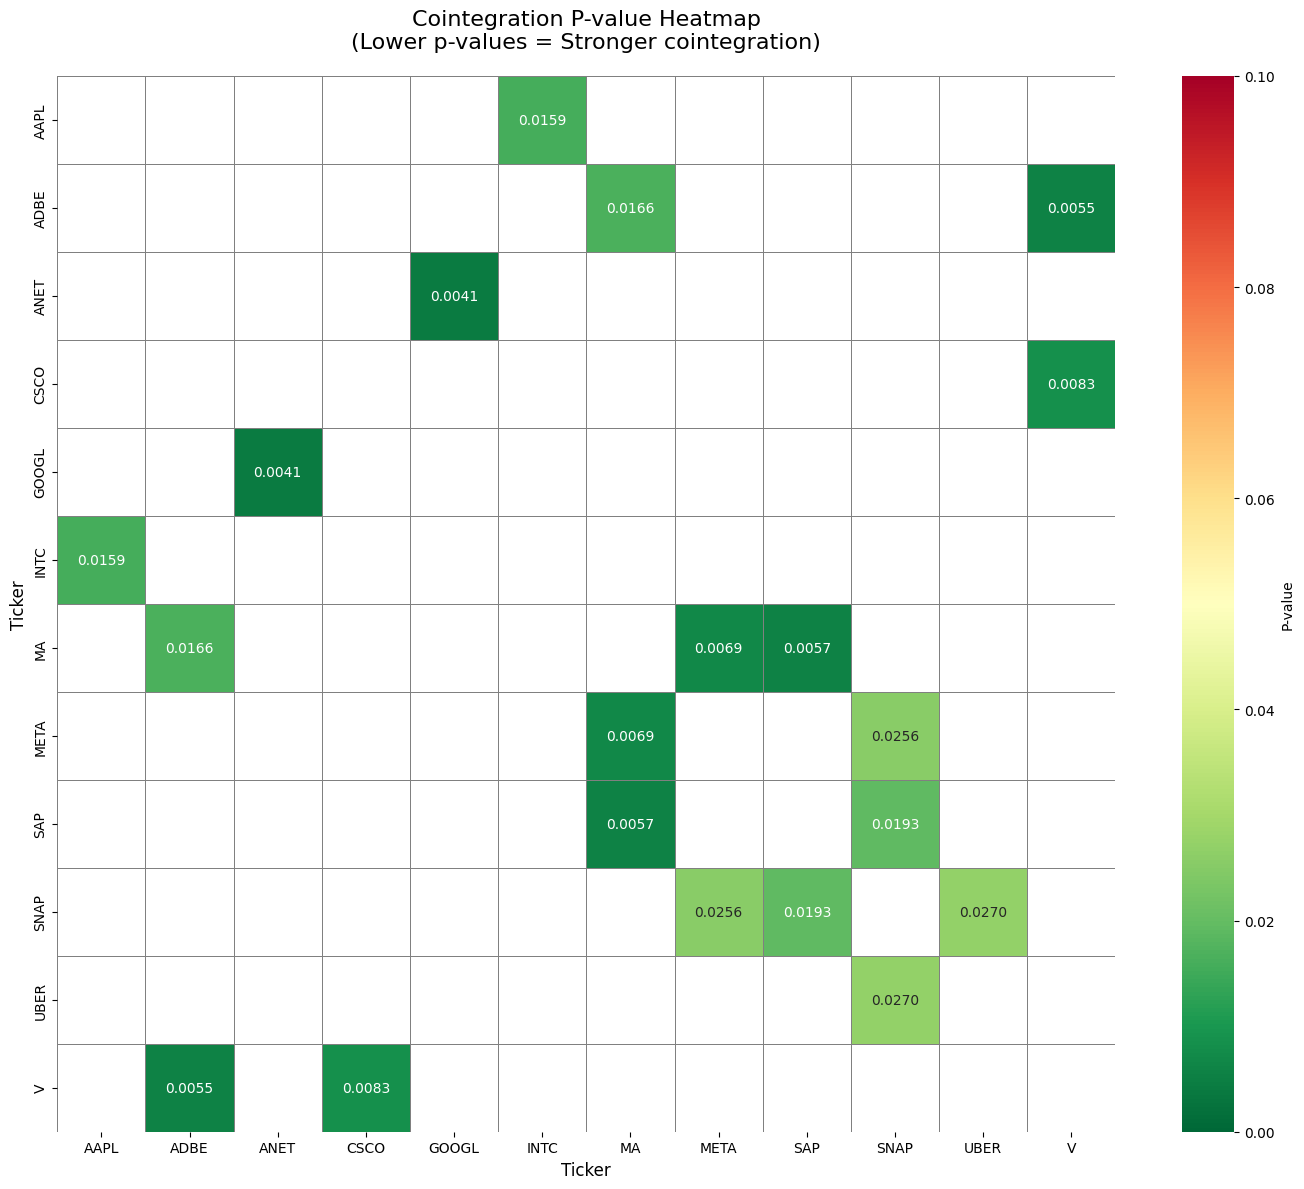


✓ Heatmap generated for 12 tickers


In [133]:

print("Generating p-value heatmap...")
pvalue_matrix, tickers_in_heatmap = create_pvalue_heatmap()
plt.show()

print(f"\n✓ Heatmap generated for {len(tickers_in_heatmap)} tickers")

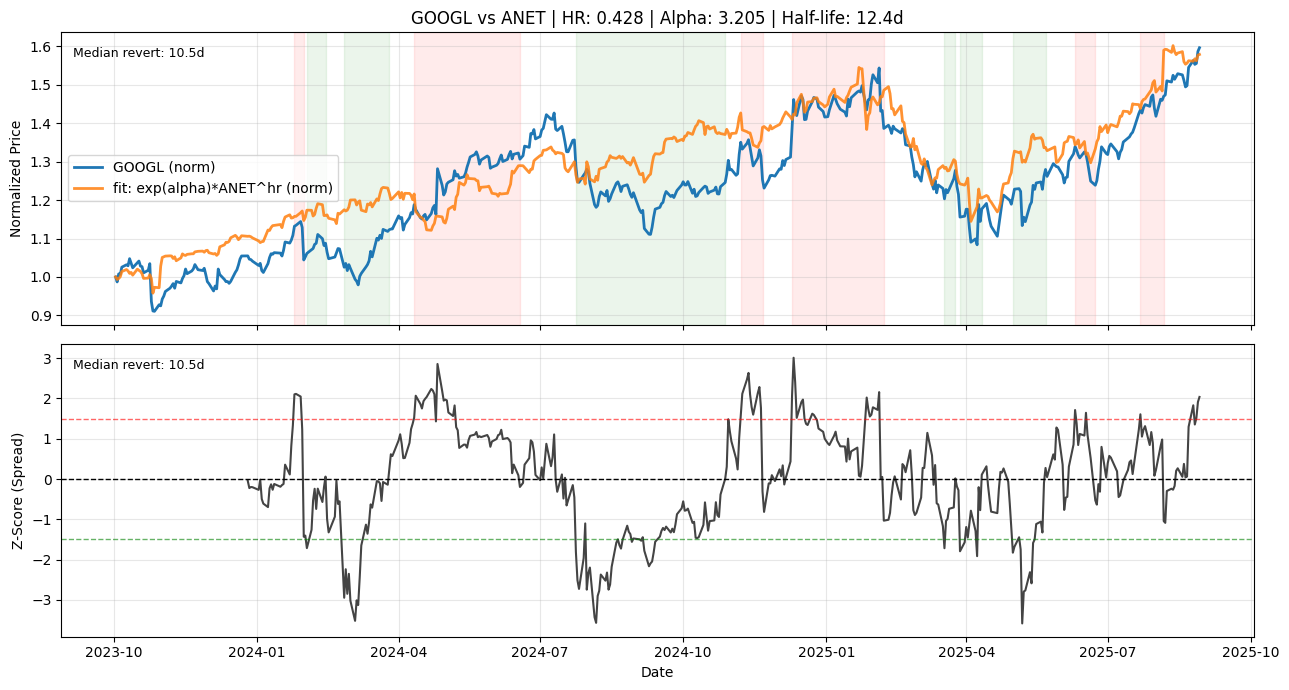

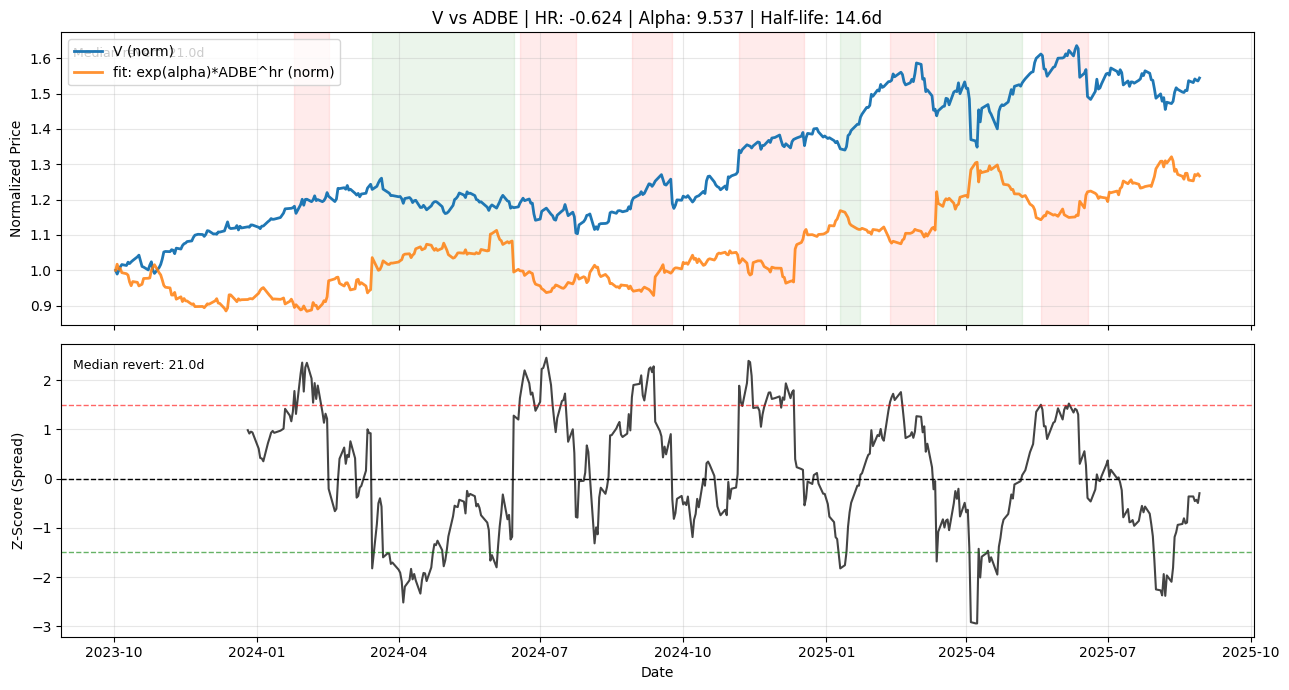

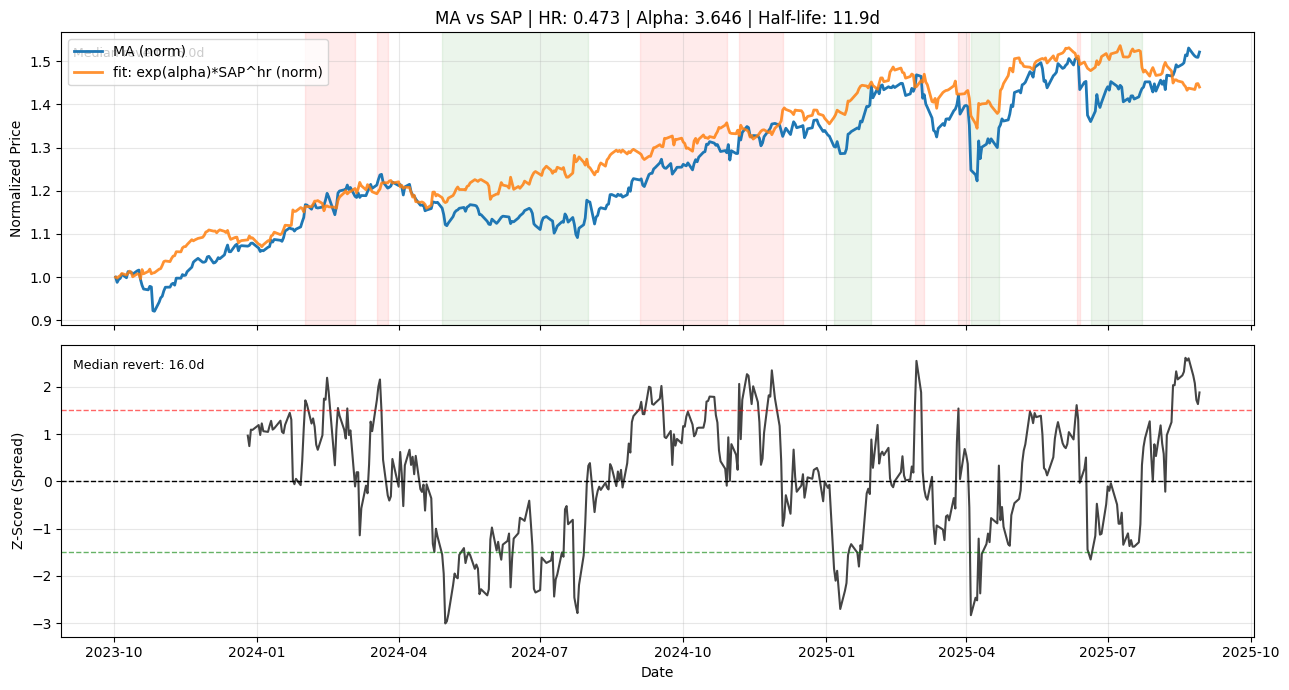

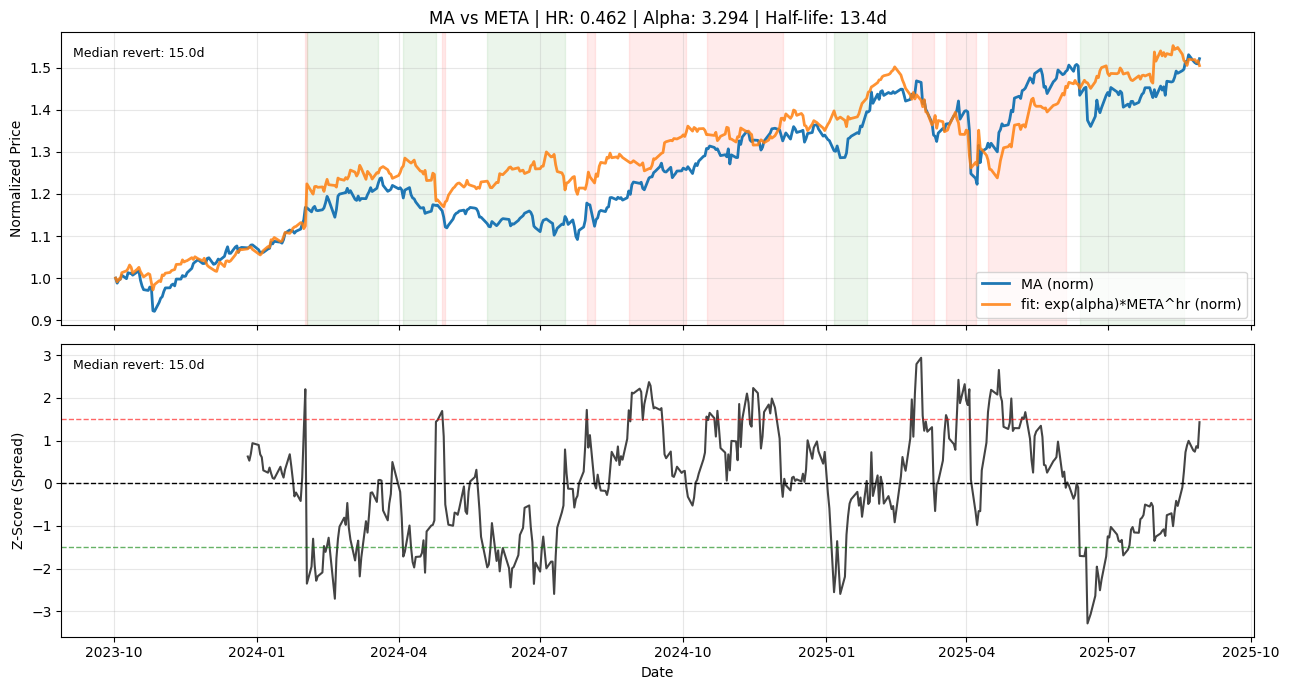

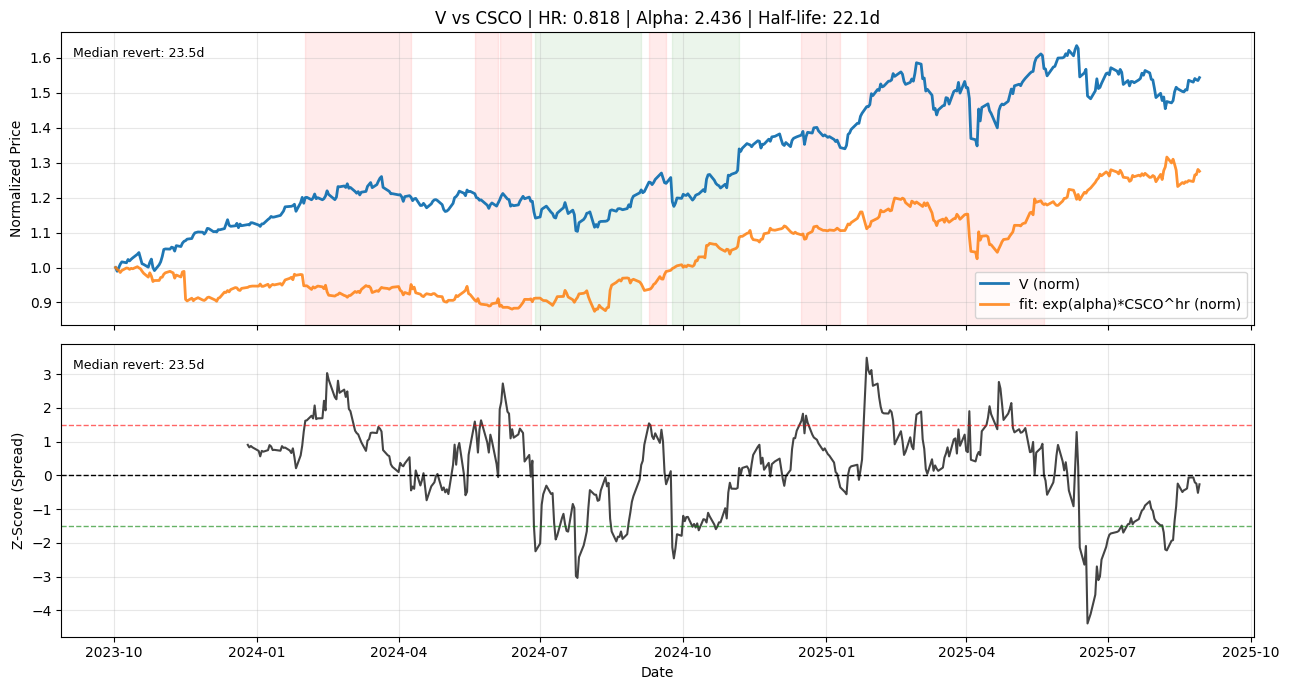

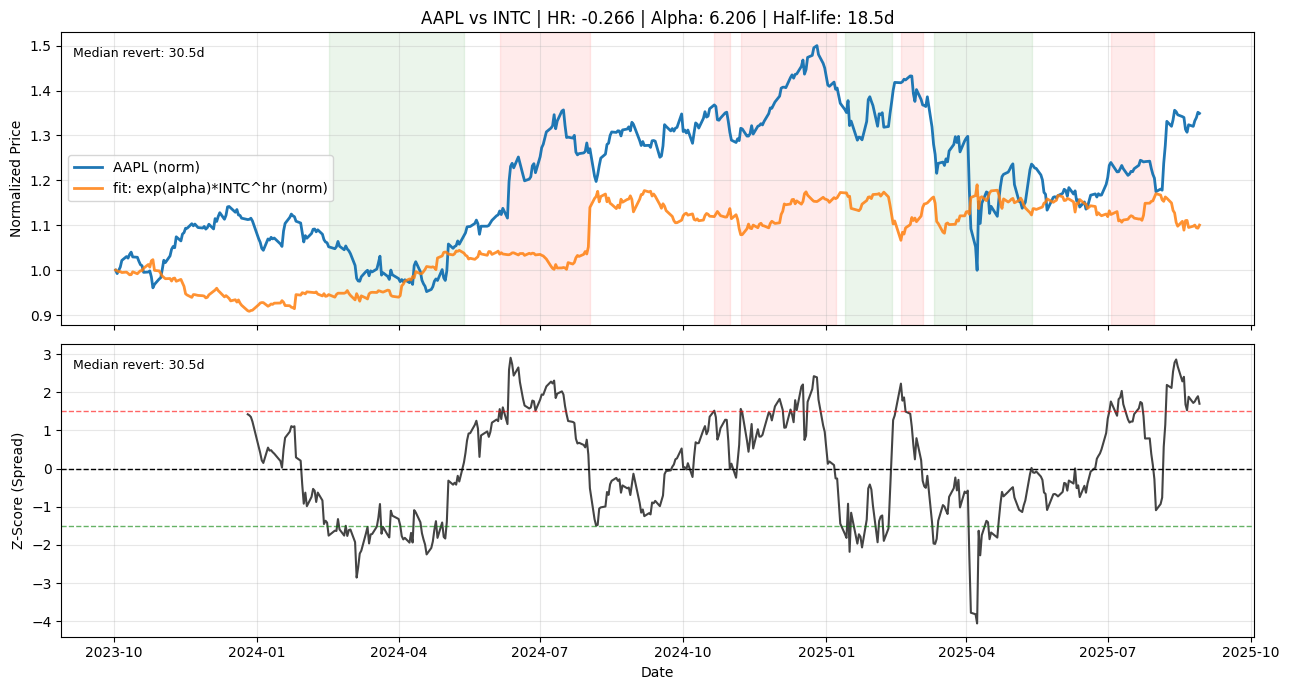

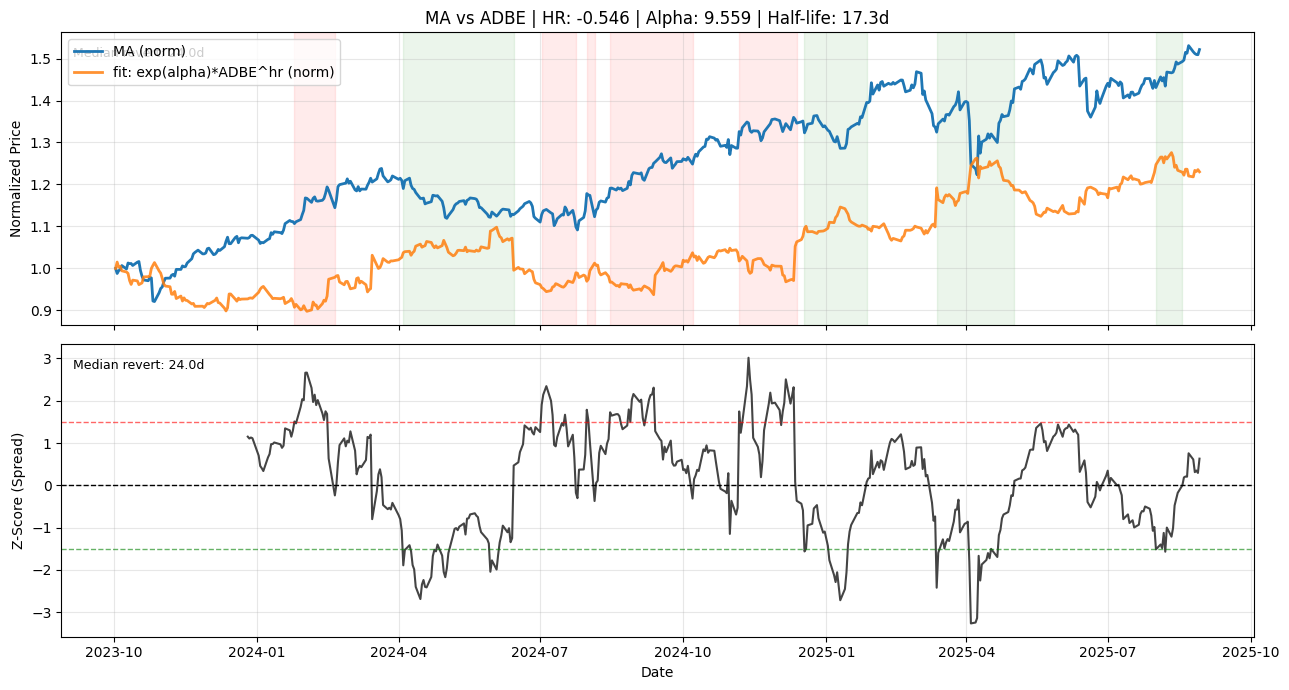

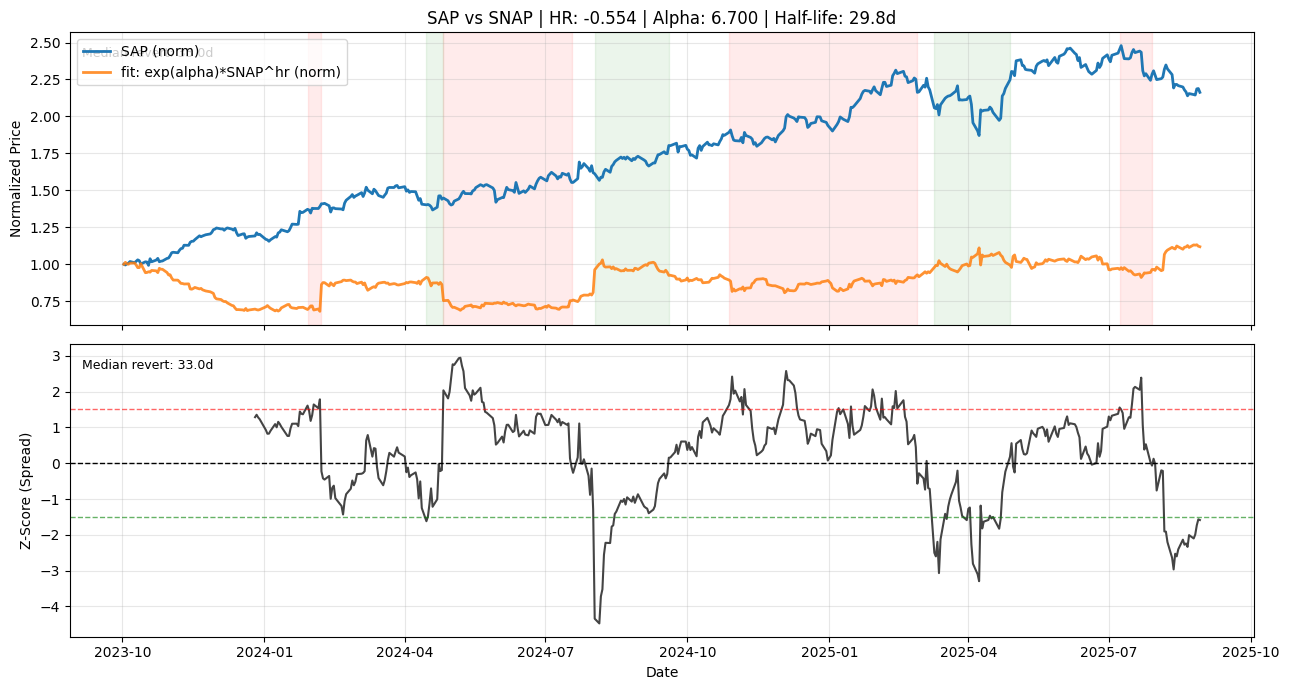

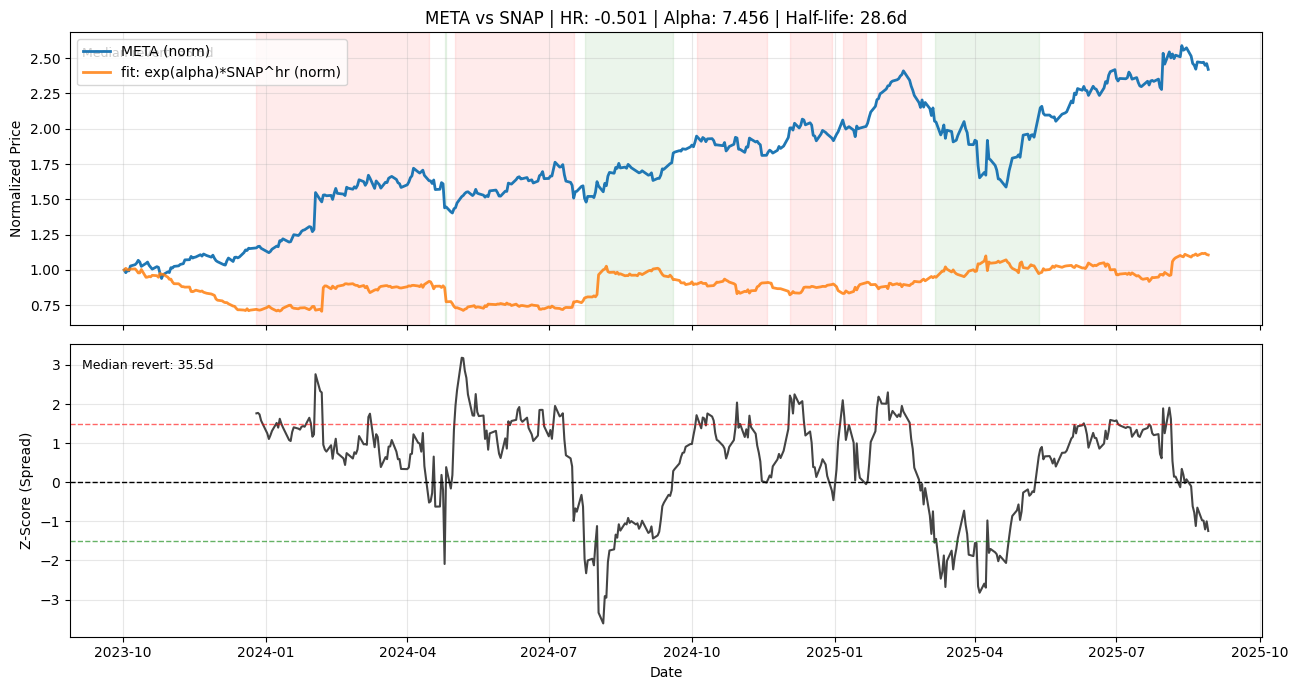

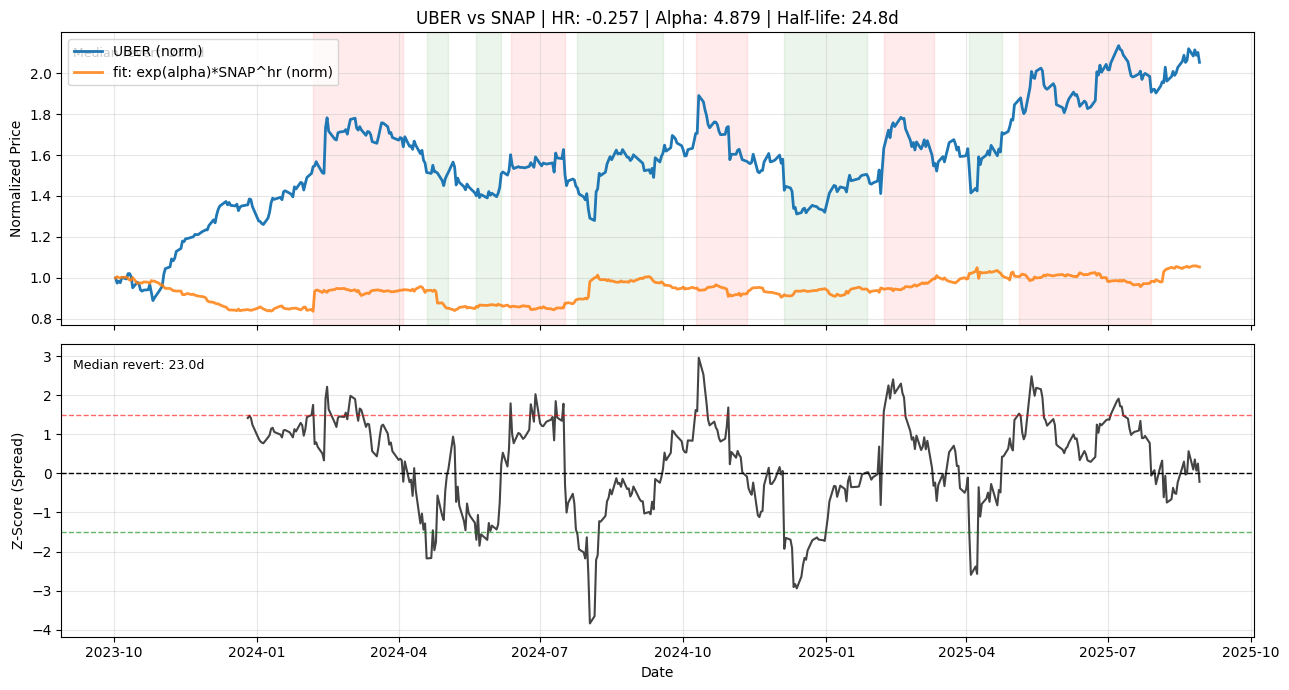

In [134]:
# ============================================================================
# PAIR COMPARISON CHARTS (Top saved pairs)
# ============================================================================

import numpy as np
import pandas as pd
from utils.stats import calculate_half_life

# Prepare datetime index for plotting
_df = df_close.copy()
if 'Date' in _df.columns:
    _df['Date'] = pd.to_datetime(_df['Date'], errors='coerce')
    _df = _df.set_index('Date').sort_index()

pairs_to_plot = cointegrated_pairs[:top_n]

for pair in pairs_to_plot:
    t1, t2 = pair['tickers']
    hr = pair['hedge_ratio']
    alpha = pair['intercept']

    c1 = f"Close__{t1}"
    c2 = f"Close__{t2}"
    if c1 not in _df.columns or c2 not in _df.columns:
        continue

    s1 = _df[c1].astype(float)
    s2 = _df[c2].astype(float)

    # Synthetic fit: price1 ≈ exp(alpha) * price2**hr
    with np.errstate(invalid='ignore'):
        s2_fit = np.exp(alpha) * (s2 ** hr)

    # Normalize both to 1 at the first common valid point
    valid = (s1.notna() & s2_fit.notna())
    if not valid.any():
        continue
    first_idx = valid[valid].index[0]
    base1 = s1.loc[first_idx]
    base2 = s2_fit.loc[first_idx]
    if pd.isna(base1) or pd.isna(base2) or base1 == 0 or base2 == 0:
        continue

    s1n = (s1 / base1).dropna()
    s2fn = (s2_fit / base2).dropna()

    # Spread and z-score (log-space, intercept-aware)
    spread = np.log(s1) - (alpha + hr * np.log(s2))
    z = (spread - spread.rolling(60).mean()) / spread.rolling(60).std()

    # Half-life estimate
    try:
        hl = calculate_half_life(spread)
    except Exception:
        hl = float('inf')

    # Estimate reversion durations: time from |z|>1.5 to next crossing of 0
    def compute_reversion_days(z_series, band=1.5):
        zc = z_series.dropna()
        days = []
        i = 0
        while i < len(zc):
            val = zc.iloc[i]
            if val > band:
                j = i + 1
                while j < len(zc) and zc.iloc[j] > 0:
                    j += 1
                if j < len(zc):
                    days.append(j - i)
                i = j
            elif val < -band:
                j = i + 1
                while j < len(zc) and zc.iloc[j] < 0:
                    j += 1
                if j < len(zc):
                    days.append(j - i)
                i = j
            else:
                i += 1
        return days

    rev_days = compute_reversion_days(z, band=1.5)
    med_rev = float(np.median(rev_days)) if len(rev_days) else np.nan

    # Build reversion intervals (from |z|>band to next zero-cross)
    def compute_reversion_intervals(z_series, band=1.5):
        zc = z_series.dropna()
        intervals = []  # (start_ts, end_ts, sign)
        i = 0
        while i < len(zc):
            val = zc.iloc[i]
            if val > band:
                start_ts = zc.index[i]
                j = i + 1
                while j < len(zc) and zc.iloc[j] > 0:
                    j += 1
                if j < len(zc):
                    intervals.append((start_ts, zc.index[j], 1))
                i = j
            elif val < -band:
                start_ts = zc.index[i]
                j = i + 1
                while j < len(zc) and zc.iloc[j] < 0:
                    j += 1
                if j < len(zc):
                    intervals.append((start_ts, zc.index[j], -1))
                i = j
            else:
                i += 1
        return intervals

    intervals = compute_reversion_intervals(z, band=1.5)

    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(13, 7), sharex=True)

    ax = axes[0]
    ax.plot(s1n.index, s1n.values, label=f"{t1} (norm)", lw=2)
    ax.plot(s2fn.index, s2fn.values, label=f"fit: exp(alpha)*{t2}^hr (norm)", lw=2, alpha=0.85)
    # Shade mean-reversion intervals on normalized chart
    for start_ts, end_ts, sgn in intervals:
        color = 'red' if sgn > 0 else 'green'
        ax.axvspan(start_ts, end_ts, color=color, alpha=0.08)
    ttl = f"{t1} vs {t2} | HR: {hr:.3f} | Alpha: {alpha:.3f}"
    if np.isfinite(hl):
        ttl += f" | Half-life: {hl:.1f}d"
    ax.set_title(ttl)
    ax.text(0.01, 0.95, f"Median revert: {med_rev:.1f}d", transform=ax.transAxes, fontsize=9, va='top')
    ax.set_ylabel('Normalized Price')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')

    ax2 = axes[1]
    ax2.plot(z.index, z.values, color='#444', lw=1.5)
    ax2.axhline(0, color='black', ls='--', lw=1)
    ax2.axhline(1.5, color='red', ls='--', lw=1, alpha=0.6)
    ax2.axhline(-1.5, color='green', ls='--', lw=1, alpha=0.6)
    ax2.text(0.01, 0.95, f"Median revert: {med_rev:.1f}d", transform=ax2.transAxes, fontsize=9, va='top')
    ax2.set_ylabel('Z-Score (Spread)')
    ax2.set_xlabel('Date')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

